In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import DenseNet121

import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel('ERROR')

In [5]:
base_dir = "../data/processed"
train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")
test_dir  = os.path.join(base_dir, "test")

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 20

print("Train:", len(train_dir))
print("Val:", len(val_dir))
print("Test:", len(test_dir))

Train: 23
Val: 21
Test: 22


In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 216 images belonging to 3 classes.
Found 48 images belonging to 3 classes.
Found 48 images belonging to 3 classes.


In [7]:
labels = train_generator.classes

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)

class_weights = dict(enumerate(class_weights))
class_weights


{0: 0.782608695652174, 1: 1.1612903225806452, 2: 1.1612903225806452}

In [8]:
densenet_base = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

for layer in densenet_base.layers:
    layer.trainable = False

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

densenet_model = Sequential([
    densenet_base,
    GlobalAveragePooling2D(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation="softmax")
])

densenet_model.summary()
    

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 771       
                                                                 
Total params: 7300675 (27.85 MB)
Trainable params: 263171 (1.00 MB)
Non-trainable params: 7037504 (26.85 MB)
_____________

In [9]:
from tensorflow.keras.optimizers import Adam

densenet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [11]:
import os

base_dir = os.path.dirname(os.getcwd())   # one level up from notebook
model_dir = os.path.join(base_dir, "models")

os.makedirs(model_dir, exist_ok=True)
print("Models will be saved to:", model_dir)


Models will be saved to: C:\Users\Mounika\models


In [12]:
densenet_callbacks = [
    ModelCheckpoint(
        os.path.join(model_dir, "best_densenet121.h5"),
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=2,
        verbose=1
    )
]


In [13]:
densenet_history = densenet_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=densenet_callbacks
)


Epoch 1/20
14/14 [==============================] - ETA: 0s - loss: 1.1994 - accuracy: 0.4352
Epoch 1: val_loss improved from inf to 0.78668, saving model to C:\Users\Mounika\models\best_densenet121.h5
14/14 [==============================] - 64s 3s/step - loss: 1.1994 - accuracy: 0.4352 - val_loss: 0.7867 - val_accuracy: 0.7292 - lr: 1.0000e-04
Epoch 2/20
14/14 [==============================] - ETA: 0s - loss: 1.0982 - accuracy: 0.5139
Epoch 2: val_loss improved from 0.78668 to 0.62625, saving model to C:\Users\Mounika\models\best_densenet121.h5
14/14 [==============================] - 37s 3s/step - loss: 1.0982 - accuracy: 0.5139 - val_loss: 0.6263 - val_accuracy: 0.8542 - lr: 1.0000e-04
Epoch 3/20
14/14 [==============================] - ETA: 0s - loss: 0.8632 - accuracy: 0.5833
Epoch 3: val_loss improved from 0.62625 to 0.54769, saving model to C:\Users\Mounika\models\best_densenet121.h5
14/14 [==============================] - 37s 3s/step - loss: 0.8632 - accuracy: 0.5833 - val_l

In [14]:
densenet_test_loss, densenet_test_acc = densenet_model.evaluate(test_generator)
print("DenseNet121 Test Accuracy:", densenet_test_acc)


3/3 [==============================] - 6s 2s/step - loss: 0.3850 - accuracy: 0.8958
DenseNet121 Test Accuracy: 0.8958333134651184


3/3 [==============================] - 6s 2s/step


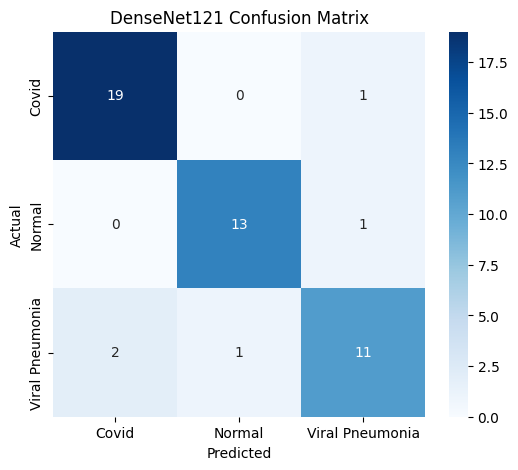

                 precision    recall  f1-score   support

          Covid       0.90      0.95      0.93        20
         Normal       0.93      0.93      0.93        14
Viral Pneumonia       0.85      0.79      0.81        14

       accuracy                           0.90        48
      macro avg       0.89      0.89      0.89        48
   weighted avg       0.89      0.90      0.89        48



In [16]:
pred_probs = densenet_model.predict(test_generator)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = test_generator.classes

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm_densenet = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_densenet,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=test_generator.class_indices.keys(),
    yticklabels=test_generator.class_indices.keys()
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("DenseNet121 Confusion Matrix")
plt.show()

print(classification_report(
    true_labels,
    pred_labels,
    target_names=test_generator.class_indices.keys()
))


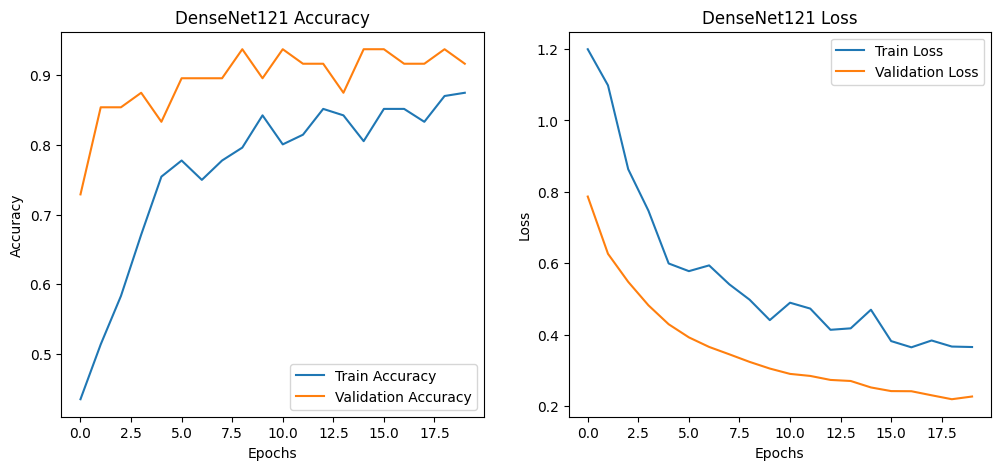

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(densenet_history.history["accuracy"], label="Train Accuracy")
plt.plot(densenet_history.history["val_accuracy"], label="Validation Accuracy")
plt.title("DenseNet121 Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(densenet_history.history["loss"], label="Train Loss")
plt.plot(densenet_history.history["val_loss"], label="Validation Loss")
plt.title("DenseNet121 Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()
